In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-04_03-03_20180601_20191231_th60_per12_sm5.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

ES       0.25
NQ       0.25
YM       0.25
GC       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    16995.4
GC      877.2
NQ    37466.8
YM    28477.4
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

83816.79999999999

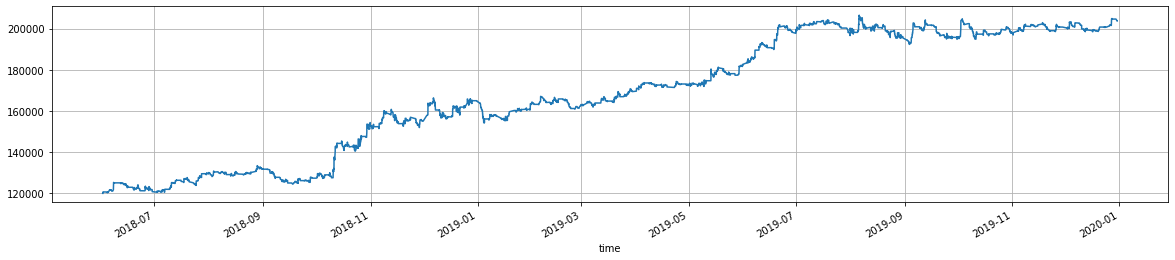

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     777
 GC    1341
 NQ    2142
 YM     757
 Name: action, dtype: int64,
 5017)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.885922
 GC    3.254854
 NQ    5.199029
 YM    1.837379
 Name: action, dtype: float64,
 12.177184466019417)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1631.70
GC    3245.22
NQ    4498.20
YM    1589.70
Name: commission, dtype: float64

In [15]:
df.commission.sum()

10964.820000000002

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.39,1.31,420.33,-266.09,1.58,1.61,670.0
NQ,0.40,34.98,450.77,-246.11,1.83,32.64,1071.0
YM,0.40,75.34,711.40,-347.77,2.05,75.90,378.0
ES,0.41,43.80,802.76,-477.57,1.68,47.37,388.0
total,0.40,33.43,537.62,-302.24,1.78,33.70,2507.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.068782,0.231872,0.468271,0.760476
GC,0.068782,1.000000,0.043186,0.035671,0.367588
NQ,0.231872,0.043186,1.000000,0.205380,0.631944
YM,0.468271,0.035671,0.205380,1.000000,0.694526
total,0.760476,0.367588,0.631944,0.694526,1.000000


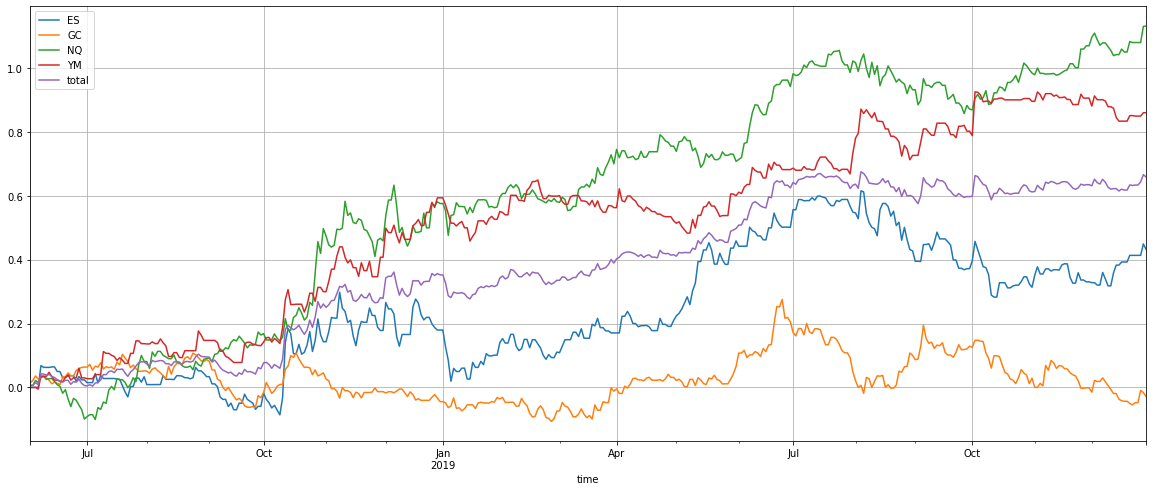

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

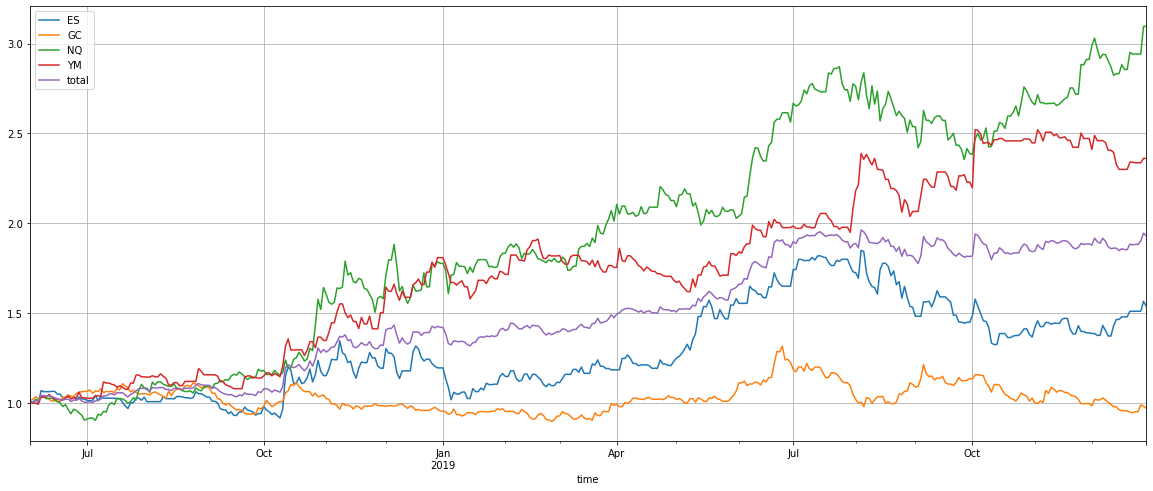

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.302219,-0.017144,0.996635,0.691628,0.495974
Cumulative returns,0.539923,-0.027876,2.097166,1.361893,0.931910
Annual volatility,0.410988,0.266758,0.381157,0.334740,0.221779
Sharpe ratio,0.843111,0.067045,2.004124,1.734500,1.926342
Calmar ratio,1.068145,-0.061035,5.550909,4.519291,5.220583
Stability,0.667475,0.040101,0.924761,0.927955,0.928060
Max drawdown,-0.282938,-0.280889,-0.179544,-0.153039,-0.095004
Omega ratio,1.186201,1.011987,1.450139,1.456451,1.447197
Sortino ratio,1.468174,0.107720,3.557738,3.613210,3.750822
Skew,1.441251,0.848424,0.757186,1.931056,1.729805


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,2.39,6.59,-9.42,3.04,0.59
2018-07-31,0.99,-1.18,19.79,11.30,7.70
2018-08-31,0.04,3.56,0.89,1.02,1.57
2018-09-30,-8.86,-11.23,7.64,-1.62,-3.66
2018-10-31,22.38,8.10,39.50,18.39,22.48
2018-11-30,3.58,-5.72,-3.79,11.38,1.77
2018-12-31,0.15,-3.08,12.43,20.42,7.63
2019-01-31,-2.65,1.34,3.18,-4.50,-0.35
2019-02-28,-4.13,-4.23,-2.57,5.26,-1.33


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        54.0
GC        -3.0
NQ       210.0
YM       136.0
total     93.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:43:00,YM,BUY,26059.00,4410.80
2018-10-11 04:23:00,ES,BUY,2766.50,4245.80
2019-06-20 03:04:00,GC,SELL,1392.40,3105.16
2018-10-31 15:48:00,NQ,SELL,6989.50,2965.80
2018-12-03 15:47:00,YM,SELL,25943.00,2855.80
...,...,...,...,...
2018-12-21 00:01:30,ES,BUY,2488.75,-1391.70
2018-12-26 11:04:00,ES,BUY,2360.75,-1454.20
2018-10-30 14:54:30,ES,BUY,2666.75,-1479.20


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2018-10-11,0.188190,0.048355,0.059660,0.090940,0.096786
2019-10-02,0.062637,0.022021,0.036273,0.147027,0.066989
2018-12-03,0.091527,-0.003989,0.082273,0.095193,0.066251
2019-09-05,0.054443,0.068677,0.070387,0.041887,0.058848
2019-08-05,0.091387,0.007021,0.035793,0.078747,0.053237
...,...,...,...,...,...
2019-08-26,-0.054863,-0.003140,-0.009280,-0.043613,-0.027724
2018-11-15,-0.047920,-0.015989,-0.029340,-0.024280,-0.029382
2018-12-10,-0.029447,0.006677,-0.080313,-0.023253,-0.031584
